# Data Augmentation

As demonstrated in the EDA notebook of this project, there are marked differences between wheat images across domains. The original challenge pre-divided the image dataset into train, test, and validation folders, with *completely distinct* sets of domains in each folder. Even if the images were apparently very similar across domains, this would not be a wise project design. But we've also demonstrated that there are clear differences between images from varying domains. To correct for this, we will combine the pre-divided train, test, and validation folders, augment the full set of data to account for any class imbalances, and then re-split into testing, training, and validation folders with even (or, as even as possible) representation across image sets. 

In [91]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

In [3]:
test = pd.read_csv('gwhd_2021/competition_test.csv')
train = pd.read_csv('gwhd_2021/competition_train.csv')
val = pd.read_csv('gwhd_2021/competition_val.csv')

In [7]:
full = pd.concat([train, test, val])

We'll save this full dataframe to a csv file:

In [12]:
# full.to_csv('transformed_data/train_test_val_concat.csv')

Now, we'll need to perform the same basic transformations to this new dataframe, as we did to the original training dataset dataframe (like reformatting of bounding box coordinates, etc). We'll also want to merge the metadata information so that we can address class imbalances when performing data augmentation and when performing the new splits. 

In [15]:
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')

In [18]:
# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [22]:
df = full.merge(metadata, on='domain')

Change image name to read `.jpg` instead of `.png`:

In [28]:
for i, row in df.iterrows():
    row['image_name'] = (row.image_name.split('.')[0]+'.jpg')

Check for duplicated images:

In [32]:
df.image_name[df.image_name.duplicated()]

2070    d88963636d49127bda0597ef73f1703e92d6f111caefc4...
2079    1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...
3948    da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...
Name: image_name, dtype: object

In [35]:
df[df.image_name == df.iloc[2070, 0]]

,image_name,BoxesString,domain,country,location,development_stage
1986,d88963636d49127bda0597ef73f1703e92d6f111caefc4...,994 8 1024 64;864 0 1012 92;642 18 772 102;616...,Arvalis_10,France,Mons,Filling
2070,d88963636d49127bda0597ef73f1703e92d6f111caefc4...,312 994 364 1024;177 756 296 869;88 118 147 17...,Arvalis_12,France,Gréoux,Filling


In [37]:
df[df.image_name == df.iloc[2079, 0]]

,image_name,BoxesString,domain,country,location,development_stage
1999,1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...,264 164 370 296;388 196 464 330;466 328 698 44...,Arvalis_10,France,Mons,Filling
2079,1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...,3 944 58 985;876 506 919 555;770 859 834 903;9...,Arvalis_12,France,Gréoux,Filling


In [40]:
df[df.image_name == df.iloc[3948, 0]]

,image_name,BoxesString,domain,country,location,development_stage
3821,da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...,950 39 986 165;725 2 776 226;660 31 720 92;797...,CIMMYT_1,Mexico,Ciudad Obregon,Post-flowering
3948,da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...,733 0 837 49;688 96 998 196;792 433 843 461;73...,CIMMYT_3,Mexico,Ciudad Obregon,Post-flowering


Once we define functions to display images with bounding boxes, we'll need to make sure to check out the duplicates detected above. 

In [43]:
#create data directory path and count images
data_dir = pathlib.Path('gwhd_2021/images')

In [44]:
images = list(data_dir.glob('*.jpg'))

In [45]:
df2 = df.copy()

In [46]:
for i, row in df2.iterrows():
    row['BoxesString'] = list(row['BoxesString'].split(';'))
    
df2 = df2.explode('BoxesString')
    
for i, row in df2.iterrows():
    row['BoxesString'] = list(row['BoxesString'].split(' '))

In [58]:
df2.BoxesString = df2.BoxesString.apply(lambda y: list('0 0 0 0'.split(" ")) if len(y)==1 else y)

In [61]:
bbox_xmin = []
bbox_ymin = []
bbox_width = []
bbox_height = []

In [63]:
df_lst = list(df2.BoxesString)

In [64]:
for bbox_lst in df_lst:
    bbox_xmin.append(bbox_lst[0])
    bbox_ymin.append(bbox_lst[1])
    bbox_width.append(bbox_lst[2])
    bbox_height.append(bbox_lst[3])

In [66]:
df2['bbox_xmin'] = bbox_xmin
df2['bbox_ymin'] = bbox_ymin
df2['bbox_xmax'] = bbox_width
df2['bbox_ymax'] = bbox_height

In [68]:
df2.reset_index(inplace=True, drop=True)

In [69]:
df2.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99,692,160,764
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641,27,697,115
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935,978,1012,1020
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377,834,463,890
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654,797,696,837


In [82]:
df2.dtypes

image_name           object
BoxesString          object
domain               object
country              object
location             object
development_stage    object
bbox_xmin            object
bbox_ymin            object
bbox_xmax            object
bbox_ymax            object
dtype: object

In [86]:
df2 = df2.astype({'bbox_xmin': 'float', 'bbox_ymin': 'float', 'bbox_xmax': 'float', 'bbox_ymax': 'float'})

In [87]:
df2.dtypes

image_name            object
BoxesString           object
domain                object
country               object
location              object
development_stage     object
bbox_xmin            float64
bbox_ymin            float64
bbox_xmax            float64
bbox_ymax            float64
dtype: object

In [88]:
# Take dataframe and image_name for which we want bounding boxes and return list of x, y, w, h

def get_all_bboxes(df, image_name):
    image_bounding_boxes = df[df.image_name == image_name]
  
    bounding_boxes = []
    for _, row in image_bounding_boxes.iterrows():
        bounding_boxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_xmax-row.bbox_xmin, row.bbox_ymax-row.bbox_ymin))
    
    return bounding_boxes

In [89]:
# Plot examples of images with their bounding boxes

def plot_image_examples(dataframe, rows = 3, cols = 3, title = 'Image examples', size = (10, 10)):
    fig, axs = plt.subplots(rows, cols, figsize=size)
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(dataframe), size = 1)[0]
            img_id = dataframe.iloc[idx].image_name
      
            img = Image.open(data_dir / img_id)
            axs[row, col].imshow(img)
      
            bboxes = get_all_bboxes(dataframe, img_id)
      
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
                axs[row, col].add_patch(rect)
        
                axs[row, col].axis('off')    
    plt.suptitle(title, fontsize = 18)

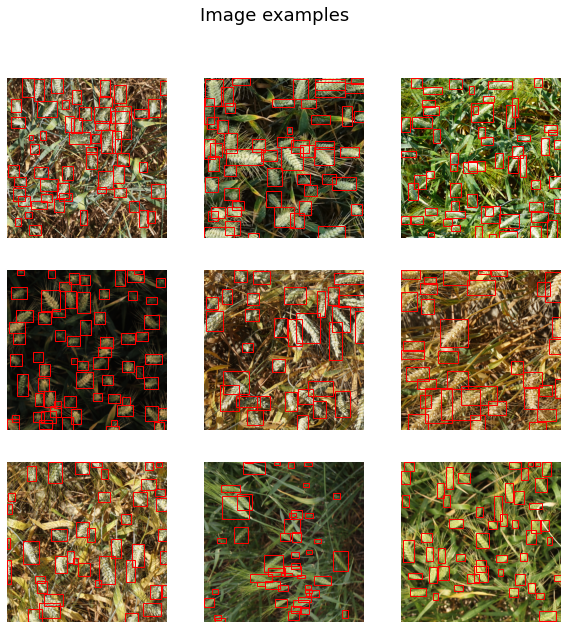

In [92]:
plot_image_examples(df2)